In [8]:
import keras
import warnings

import numpy as np

import matplotlib.pyplot as plt

from slackclient import SlackClient
from io import BytesIO #to post matplotlib graphs to slack



class SlackCallback(keras.callbacks.Callback):
    def __init__(self, token, channel='#general', 
                 best_only=False, monitor='val_loss', 
                 mode='min',message='Epoch {epoch:03d} loss:{val_loss:.4f} val_loss:{val_loss:.4f}',
                 model_description='Start of training',
                 plot=['loss','val_loss']):
        super(SlackCallback, self).__init__()
        self.losses=[]
        self.error=False
        
        self.token=token
        self.channel=channel
        self.best_only=best_only
        
        self.monitor=monitor
        
        self.model_description=model_description
        
        self.ts=None
        self.message=message
        
        if mode=='min':
            self.operation=np.less
            self.best=np.Inf
        if mode=='max':
            self.operation=np.greater
            self.best=-np.Inf
        
        self.best_logs={}
        self.best_epoch=1
        self.plot=plot or []
    
    def on_train_begin(self, logs={}):
        #create new thread or should I move it to init? This would put all subsequent model trainings into a single thread
        #or alternatively clear self.losses and start from the scratch every time the model is trained
        response=self.send_message(self.model_description)
        if response['ok']:
            self.error=False
            self.ts=response['ts']
        else:
            self.error=True
            warnings.warn('Slack error:'+str(response))
        

    def on_epoch_end(self, epoch, logs={}):
        #send message to the thread
        self.losses.append(logs)
        if self.best_only:
            if self.operation(logs[self.monitor],self.best):
                self.send_message(self.message.format(epoch=epoch+1,**logs))
                self.best=logs[self.monitor]
                self.best_logs=logs
                self.best_epoch=epoch+1
        else:        
            self.send_message(self.message.format(epoch=epoch,**logs))

    def on_train_end(self, logs=None):
        #Report best results and plot losses
        self.send_message('Best results:\n'+self.message.format(epoch=self.best_epoch,**self.best_logs))
        for p in self.plot:
            plt.plot([log[p] for log in self.losses])
            
        out = BytesIO()
        plt.savefig(fname=out,format='png')
        out.seek(0)
        response=self.send_image(filename='LearningCurve.png',image=out)
        plt.show()
            
    def send_message(self,text,**kwargs):
        try:
            return self.send_slack_message(token=self.token,channel=self.channel,text=text, ts=self.ts,attachments=kwargs['attachments'])
        except:
            #print('No attachments')
            #print(kwargs)
            pass
        if not self.error:
            return self.send_slack_message(token=self.token,channel=self.channel,text=text, ts=self.ts,**kwargs)
    
    def send_image(self,filename, image):
        if not self.error:
            response=self.attach_slack_file(token=self.token,channel=self.channel, ts=self.ts,filename=filename,file=image)
            if response['ok']:
                attachments={'attachments':{'fallback':'Learning curves fallback','title':'Learning curves title','image_url':response['file']['url_private']}}
                return self.send_slack_attachment(token=self.token,channel=self.channel,text='', ts=self.ts,attachments=attachments)

        
    def send_slack_message(self, token,channel, text,ts=None,**kwargs):
        sc = SlackClient(token)
        return sc.api_call("chat.postMessage",channel=channel,text=text,thread_ts=ts,**kwargs)

    def send_slack_attachment(self, token,channel, text,ts=None,attachments=None):
        sc = SlackClient(token)
        return sc.api_call("chat.postMessage",channel=channel,text=text,thread_ts=ts,attacments=attachments)


    def attach_slack_file(self, token,channel,ts, filename,file,**kwargs):
        sc = SlackClient(token)
        return sc.api_call('files.upload', channel=channel, as_user=True, thread_ts=ts, filename=filename, file=file,**kwargs)



In [15]:
'''Trains a simple deep NN on the MNIST dataset.

Gets to 98.40% test accuracy after 20 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

batch_size = 128
num_classes = 10
epochs = 10

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 127.5-1.0
x_test /= 127.5-1
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


In [16]:
#Assigning token directly in your code is a security flaw
#I did it just for simplicity
#Better use
#http://python-slackclient.readthedocs.io/en/latest/auth.html#handling-tokens
token='xoxp-your token'
description='Mnist model MLP 512-RELU-DO0.2-512-RELU-DO0.2'
message='Epoch {epoch:03d} loss:{val_loss:.4f} acc:{acc:.4f} val_loss:{val_loss:.4f} val_acc:{val_acc:.4f} '

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.2857 - acc: 0.9120 - val_loss: 0.1297 - val_acc: 0.9610
Epoch 2/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.1370 - acc: 0.9592 - val_loss: 0.0882 - val_acc: 0.9733
Epoch 3/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.1061 - acc: 0.9687 - val_loss: 0.0821 - val_acc: 0.9754
Epoch 4/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.0915 - acc: 0.9731 - val_loss: 0.0827 - val_acc: 0.9760
Epoch 5/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.0812 - acc: 0.9772 - val_loss: 0.0731 - val_acc: 0.9809
Epoch 6/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.0758 - acc: 0.9785 - val_loss: 0.0740 - val_acc: 0.9802
Epoch 7/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.0728 - acc: 0.9797 - val_loss: 0.0736 - val_acc

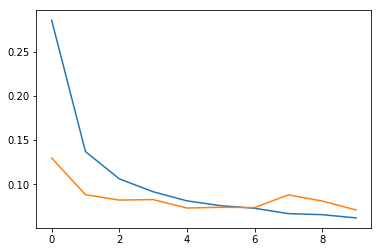

Test loss: 0.07095375152574589
Test accuracy: 0.9837


In [17]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,), kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

#model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])


slack=SlackCallback(token, channel='#general', model_description=description,mode='max', monitor='val_acc',message=message,best_only=True)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),callbacks=[slack])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
